In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

In [48]:
#!pip install flwr_datasets[vision]


In [66]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import flwr as fl
from flwr.common import Metrics

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.1.2+cu121 and Flower 1.6.0


# CIFAR 10 DATASET

In [67]:
# we naturally first need to import torch and torchvision
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import CIFAR10


def get_mnist(data_path: str = "./data"):
    """This function downloads the MNIST dataset into the `data_path`
    directory if it is not there already. WE construct the train/test
    split by converting the images into tensors and normalising them"""

    # transformation to convert images to tensors and apply normalisation
    tr = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])

    # prepare train and test set
    trainset = MNIST(data_path, train=True, download=True, transform=tr)
    testset = MNIST(data_path, train=False, download=True, transform=tr)

    return trainset, testset

In [68]:
trainset, testset = get_mnist()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 17336222.41it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 20785122.48it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 15820950.96it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 3414073.26it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Text(0.5, 1.0, 'Class labels distribution for MNIST')

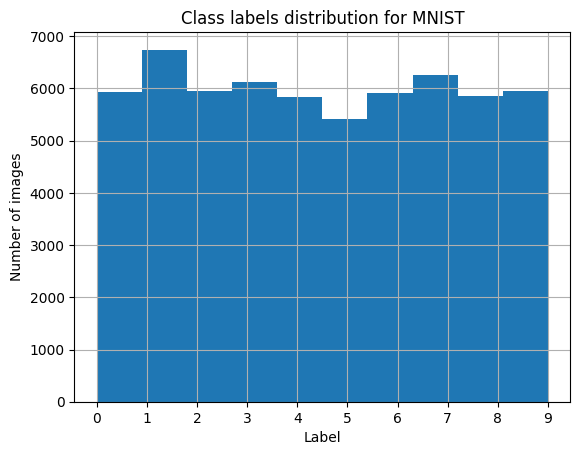

In [69]:
import matplotlib.pyplot as plt


# construct histogram
all_labels = trainset.targets
num_possible_labels = len(
    set(all_labels.numpy().tolist())
)  # this counts unique labels (so it should be = 10)
plt.hist(all_labels, bins=num_possible_labels)

# plot formatting
plt.xticks(range(num_possible_labels))
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution for MNIST")

In [70]:
import random
import numpy as np


def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    # take n examples at random
    idx = list(range(len(trainset_.data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_.data[i], cmap="gray")

will display images with idx: [20624, 53460, 10798, 37780, 37229, 7555, 45045, 57068, 19224, 11742, 57064, 28302, 20588, 57836, 10692, 7742, 32108, 5305, 42757, 49448, 30816, 15555, 20541, 47966, 40235, 53384, 56006, 56131, 18843, 41406, 28459, 18599]


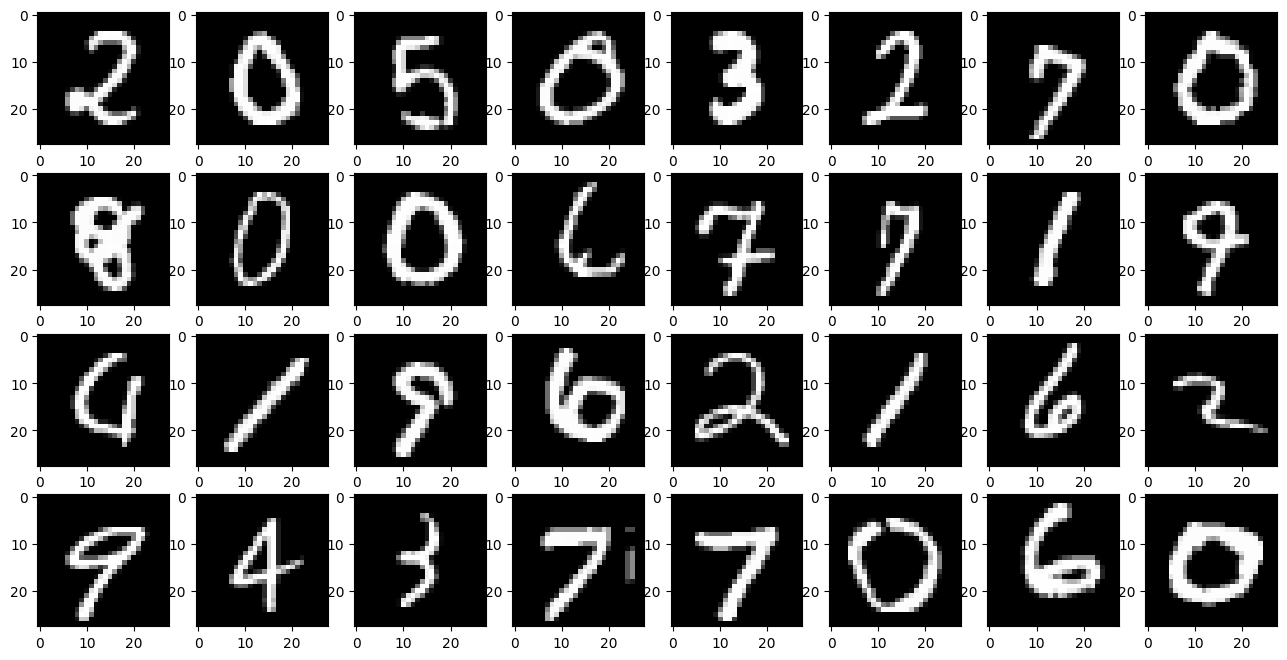

In [71]:
# it is likely that the plot this function will generate looks familiar to other plots you might have generated before
# or you might have encountered in other tutorials. So far, we aren't doing anything new, Federated Learning will start soon!
visualise_n_random_examples(trainset, n=32)

In [72]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [73]:
model = Net(num_classes=10)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


In [74]:
def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
    return net


def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

In [77]:
# instantiate the model
epochs = 10
lr = 0.1
momentum = 0.09
model = Net(num_classes=10)

# define optimiser with hyperparameters supplied
optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# get dataset and construct a dataloaders
trainset, testset = get_mnist()
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128)

# train for the specified number of epochs
trained_model = train(model, trainloader, optim, epochs)

# training is completed, then evaluate model on the test set
loss, accuracy = test(trained_model, testloader)
print(f"{loss = }")
print(f"{accuracy = }")

loss = 2.7562995556181704
accuracy = 0.9899


In [83]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [84]:
weights = get_parameters(model)

In [88]:
for i in weights:
    print(i.size)

150
6
2400
16
30720
120
10080
84
840
10


In [85]:
set_parameters(model,weights)

In [92]:
i = 1

In [95]:
 str(i).rjust(3, '0')

'001'

In [97]:
for i in range(1,101):
    name = "./onchain/models/MNIST_" + str(i).rjust(3, '0') + ".npy"
    np.save(name, np.array(weights, dtype=object), allow_pickle=True)

In [90]:
Loaded_model = np.load('./onchain/models/MNIST.npy', allow_pickle=True)